In [8]:
import os
from imutils import paths
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Input,Flatten,AveragePooling2D,Dense,Dropout
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [9]:
#loading and preprocessing our dataset
path='/content/drive/MyDrive/dataset'
imagepaths = list(paths.list_images(path))
data =[]
labels = []
for imagepath in imagepaths:
  label = imagepath.split(os.path.sep)[-2]
  image = load_img(imagepath,target_size= (224,224))
  image= img_to_array(image)
  image= preprocess_input(image)

  data.append(image)
  labels.append(label)
  
data = np.array(data,dtype='float32')
labels = np.array(labels)  

In [10]:
#processing the dataset
lb = LabelBinarizer()
labels= lb.fit_transform(labels)
labels = to_categorical(labels)

(trainx,testx,trainy,testy)= train_test_split(data,labels,test_size=0.2,stratify = labels)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


In [11]:
#loading the MobileNetv2 model and ensuring that include_top=False
basemodel = MobileNetV2(weights = 'imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(7,7))(headmodel)
headmodel = Flatten(name='flatten')(headmodel)
headmodel = Dense(128,activation = 'relu')(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(2,activation='softmax')(headmodel)

model = Model(inputs=basemodel.input,outputs = headmodel)

#freezing the layers of basemodel
for layer in basemodel.layers:
  layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [12]:
#training the model
opt = Adam(lr=1e-4,decay=1e-4/20)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

hist=model.fit(aug.flow(x=trainx,y=trainy,batch_size=32),epochs=20,steps_per_epoch=len(trainx)//32,
          validation_data=(testx,testy),validation_steps=len(testy)//32)



Epoch 1/20
34/34 [==============================] - 59s 2s/step - loss: 0.5991 - accuracy: 0.7324 - val_loss: 0.1968 - val_accuracy: 0.9819
Epoch 2/20
34/34 [==============================] - 54s 2s/step - loss: 0.2347 - accuracy: 0.9581 - val_loss: 0.0904 - val_accuracy: 0.9964
Epoch 3/20
34/34 [==============================] - 53s 2s/step - loss: 0.1285 - accuracy: 0.9717 - val_loss: 0.0544 - val_accuracy: 0.9964
Epoch 4/20
34/34 [==============================] - 53s 2s/step - loss: 0.0878 - accuracy: 0.9840 - val_loss: 0.0384 - val_accuracy: 0.9964
Epoch 5/20
34/34 [==============================] - 53s 2s/step - loss: 0.0733 - accuracy: 0.9873 - val_loss: 0.0293 - val_accuracy: 0.9964
Epoch 6/20
34/34 [==============================] - 53s 2s/step - loss: 0.0478 - accuracy: 0.9897 - val_loss: 0.0246 - val_accuracy: 0.9964
Epoch 7/20
34/34 [==============================] - 52s 2s/step - loss: 0.0474 - accuracy: 0.9944 - val_loss: 0.0201 - val_accuracy: 0.9964
Epoch 8/20
34/34 [==

In [13]:
#predicting on test data
predictions = model.predict(testx,batch_size=32)
preidx = np.argmax(predictions,axis=1)

print(classification_report(testy.argmax(axis=1),preidx,target_names=lb.classes_))

model.save('mask_detector.model',save_format="h5")


              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       138
without_mask       1.00      0.99      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



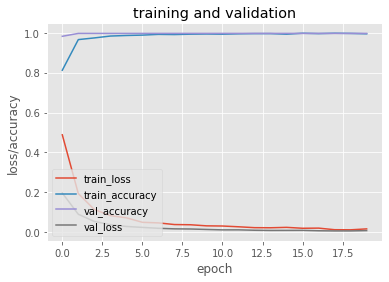

In [14]:
#plotting the training loss and accuracy
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,20),hist.history['loss'],label='train_loss')
plt.plot(np.arange(0,20),hist.history['accuracy'],label='train_accuracy')
plt.plot(np.arange(0,20),hist.history['val_accuracy'],label='val_accuracy')
plt.plot(np.arange(0,20),hist.history['val_loss'],label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.title('training and validation')
plt.legend(loc='lower left')
plt.savefig('plot.png')

